In [ ]:
#Install required packages
!pip install evaluate jiwer torchaudio librosa datasets transformers
!pip install seaborn matplotlib scikit-learn pandas numpy
!pip install torch torchaudio transformers librosa soundfile faiss-cpu pydub sentence-transformers
!pip install tensorflow-hub  # For VGGish

print(" All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.2 MB/s eta 0:00:00
 All packages installed successfully!


In [ ]:
#Import all necessary libraries
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
from sentence_transformers import SentenceTransformer
import faiss
import tensorflow_hub as hub
from pydub import AudioSegment
import os
from typing import List, Tuple, Dict

import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datasets import load_dataset
import evaluate
import warnings
warnings.filterwarnings('ignore')

import IPython.display as ipd
from IPython.display import display

print(" All libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


 All libraries imported successfully!


In [ ]:
# Audio Preprocessing Class
class AdaptiveAudioPreprocessor:
    def __init__(self, target_sr=16000):
        self.target_sr = target_sr

    def load_audio(self, audio_path: str) -> Tuple[np.ndarray, int]:
        """Load audio file and convert to target sample rate"""
        try:
            audio, sr = librosa.load(audio_path, sr=self.target_sr)
            return audio, sr
        except:
            waveform, sr = torchaudio.load(audio_path)
            if sr != self.target_sr:
                resampler = torchaudio.transforms.Resample(sr, self.target_sr)
                waveform = resampler(waveform)
            return waveform.numpy()[0], self.target_sr

    def segment_by_silence(self, audio: np.ndarray, sr: int,
                          top_db: int = 25, min_silence_len: int = 500,
                          seek_step: int = 10) -> List[Tuple[np.ndarray, float, float]]:
        """Segment audio based on silence detection for natural breaks"""
        print("Segmenting audio by silence detection...")

        # Detect non-silent chunks
        non_silent_ranges = librosa.effects.split(
            audio,
            top_db=top_db,
            frame_length=2048,
            hop_length=512
        )

        segments = []
        for start_sample, end_sample in non_silent_ranges:
            start_time = start_sample / sr
            end_time = end_sample / sr
            segment = audio[start_sample:end_sample]

            # Only include segments longer than 1 second
            if (end_time - start_time) > 1.0:
                segments.append((segment, start_time, end_time))

        print(f"✓ Found {len(segments)} natural speech segments")
        return segments

    def segment_by_fixed_length(self, audio: np.ndarray, sr: int,
                               segment_length: float = 5.0) -> List[Tuple[np.ndarray, float, float]]:
        """Segment audio into fixed-length chunks as fallback"""
        segment_samples = int(segment_length * sr)
        segments = []

        for start_sample in range(0, len(audio), segment_samples):
            end_sample = min(start_sample + segment_samples, len(audio))
            segment = audio[start_sample:end_sample]
            start_time = start_sample / sr
            end_time = end_sample / sr
            segments.append((segment, start_time, end_time))

        return segments

    def adaptive_segment(self, audio: np.ndarray, sr: int, method: str = "silence") -> List[Tuple[np.ndarray, float, float]]:
        """Adaptive segmentation based on content"""
        if method == "silence":
            segments = self.segment_by_silence(audio, sr)
            if len(segments) > 5:  # If we found reasonable segments
                return segments

        # Fallback to fixed-length segmentation
        print("Using fixed-length segmentation as fallback...")
        return self.segment_by_fixed_length(audio, sr, segment_length=8.0)

In [ ]:
#Speech-to-Text Converter
class EnhancedSpeechToTextConverter:
    def __init__(self, model_size="base"):
        self.model_size = model_size
        self.pipe = pipeline(
            "automatic-speech-recognition",
            model=f"openai/whisper-{model_size}",
            device=0 if torch.cuda.is_available() else -1
        )

    def transcribe_with_timestamps(self, audio_path: str) -> List[Dict]:
        """Transcribe audio with sentence-level timestamps"""
        print("Transcribing with sentence-level timestamps...")

        # Use Whisper with word-level timestamps for better segmentation
        result = self.pipe(
            audio_path,
            return_timestamps=True,
            chunk_length_s=30
        )

        segments = result.get("chunks", [])

        # Group words into sentences for natural segments
        sentence_segments = self._group_into_sentences(segments)

        print(f"✓ Transcribed {len(sentence_segments)} sentence segments")
        return sentence_segments

    def _group_into_sentences(self, word_chunks: List[Dict]) -> List[Dict]:
        """Group word timestamps into sentence segments"""
        sentences = []
        current_sentence = []
        sentence_end_punctuation = ['.', '!', '?', '。', '！', '？']

        for chunk in word_chunks:
            text = chunk['text'].strip()
            if not text:
                continue

            current_sentence.append(chunk)

            # Check if this chunk ends a sentence
            if any(text.endswith(punct) for punct in sentence_end_punctuation):
                if current_sentence:
                    sentences.append(self._create_sentence_segment(current_sentence))
                    current_sentence = []

        # Add any remaining words as final sentence
        if current_sentence:
            sentences.append(self._create_sentence_segment(current_sentence))

        return sentences

    def _create_sentence_segment(self, word_chunks: List[Dict]) -> Dict:
        """Create a sentence segment from word chunks"""
        full_text = ' '.join(chunk['text'].strip() for chunk in word_chunks)
        start_time = word_chunks[0]['timestamp'][0]
        end_time = word_chunks[-1]['timestamp'][1]

        return {
            'text': full_text,
            'start_time': start_time,
            'end_time': end_time,
            'word_count': len(full_text.split())
        }

In [ ]:
#Text Summarizer
class TextSummarizer:
    def __init__(self):
        self.model_name = "facebook/bart-large-cnn"
        self.tokenizer = BartTokenizer.from_pretrained(self.model_name)
        self.model = BartForConditionalGeneration.from_pretrained(self.model_name)

    def summarize_text(self, text: str, max_length: int = 150, min_length: int = 40) -> str:
        """Summarize text using BART model"""
        # Tokenize input
        inputs = self.tokenizer([text], max_length=1024, return_tensors="pt", truncation=True)

        # Generate summary
        summary_ids = self.model.generate(
            inputs["input_ids"],
            num_beams=4,
            max_length=max_length,
            min_length=min_length,
            length_penalty=2.0,
            early_stopping=True
        )

        # Decode summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

    def summarize_segments(self, transcriptions: List[Dict]) -> Dict:
        """Create overall summary and segment summaries"""
        # Combine all text for overall summary
        full_text = " ".join([t['text'] for t in transcriptions if t['text'].strip()])
        overall_summary = self.summarize_text(full_text)

        # Create segment summaries
        for transcription in transcriptions:
            if len(transcription['text'].split()) > 50:  # Only summarize longer segments
                transcription['summary'] = self.summarize_text(transcription['text'], max_length=80, min_length=20)
            else:
                transcription['summary'] = transcription['text']

        return {
            'overall_summary': overall_summary,
            'segments': transcriptions
        }

In [ ]:
#Audio Embedding Extractor
class VGGishEmbeddingExtractor:
    def __init__(self):
        # Load VGGish model from TensorFlow Hub
        self.model = hub.load("https://tfhub.dev/google/vggish/1")

    def extract_embeddings(self, audio_segment: np.ndarray, sr: int) -> np.ndarray:
        """Extract VGGish embeddings from audio segment"""
        # VGGish expects 16kHz sample rate
        if sr != 16000:
            audio_segment = librosa.resample(audio_segment, orig_sr=sr, target_sr=16000)

        # Ensure audio is in the right range for VGGish
        audio_segment = audio_segment.astype(np.float32)

        # Extract embeddings
        embeddings = self.model(audio_segment)

        return embeddings.numpy()

    def extract_segment_embeddings(self, summarized_data: Dict) -> Dict:
        """Extract embeddings for all segments"""
        for segment in summarized_data['segments']:
            audio_segment = segment['audio_segment']
            sr = 16000  # VGGish expects 16kHz

            embeddings = self.extract_embeddings(audio_segment, sr)
            # Use mean pooling across time frames
            segment['audio_embedding'] = np.mean(embeddings, axis=0)

        return summarized_data

In [ ]:
#Text Embedding Extractor
class TextEmbeddingExtractor:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

    def extract_query_embedding(self, query: str) -> np.ndarray:
        """Extract embedding for user query"""
        return self.model.encode([query])[0]

    def extract_segment_text_embeddings(self, summarized_data: Dict) -> Dict:
        """Extract text embeddings for all segments"""
        for segment in summarized_data['segments']:
            # Use summary if available, otherwise use full text
            text = segment.get('summary', segment['text'])
            segment['text_embedding'] = self.model.encode([text])[0]

        return summarized_data

In [ ]:
# Main Audio Retrieval System
class QueryAwareAudioRetrievalSystem:
    def __init__(self):
        print("Initializing Query-Aware Audio Retrieval System...")
        self.audio_preprocessor = AdaptiveAudioPreprocessor()
        self.stt_converter = EnhancedSpeechToTextConverter()
        self.summarizer = TextSummarizer()
        self.audio_embedding_extractor = VGGishEmbeddingExtractor()
        self.text_embedding_extractor = TextEmbeddingExtractor()
        self.index = None
        self.segment_data = None
        self.original_audio_path = None
        print("✓ System initialized successfully!")

    def process_audio_adaptive(self, audio_path: str):
        """Process audio with adaptive segmentation"""
        print("Processing audio with adaptive segmentation...")

        # Load audio
        audio, sr = self.audio_preprocessor.load_audio(audio_path)
        print(f"✓ Audio loaded: {len(audio)/sr:.2f} seconds")

        # Get transcription with sentence-level timestamps
        sentence_segments = self.stt_converter.transcribe_with_timestamps(audio_path)

        # If sentence segmentation failed, use silence-based segmentation
        if not sentence_segments or len(sentence_segments) < 3:
            print("Falling back to silence-based segmentation...")
            segments = self.audio_preprocessor.adaptive_segment(audio, sr, method="silence")

            # Create mock transcriptions for demo
            transcriptions = self._create_mock_transcriptions(segments, audio, sr)
        else:
            # Use the sentence segments from Whisper
            transcriptions = self._create_transcriptions_from_sentences(sentence_segments, audio, sr)

        # Create summaries and embeddings
        summarized_data = self.summarizer.summarize_segments(transcriptions)
        embedded_data = self.audio_embedding_extractor.extract_segment_embeddings(summarized_data)
        final_data = self.text_embedding_extractor.extract_segment_text_embeddings(embedded_data)

        # Build FAISS index
        self._build_faiss_index(final_data['segments'])
        self.original_audio_path = audio_path
        self.segment_data = final_data

        print(f"✓ Processing complete. {len(final_data['segments'])} segments created")
        return final_data

    def _create_transcriptions_from_sentences(self, sentence_segments: List[Dict], audio: np.ndarray, sr: int) -> List[Dict]:
        """Create transcriptions from sentence segments"""
        transcriptions = []

        for i, segment in enumerate(sentence_segments):
            start_sample = int(segment['start_time'] * sr)
            end_sample = int(segment['end_time'] * sr)
            audio_segment = audio[start_sample:end_sample] if end_sample <= len(audio) else audio[start_sample:]

            transcriptions.append({
                'segment_id': i,
                'text': segment['text'],
                'start_time': segment['start_time'],
                'end_time': segment['end_time'],
                'audio_segment': audio_segment,
                'duration': segment['end_time'] - segment['start_time']
            })

        return transcriptions

    def _create_mock_transcriptions(self, segments: List, audio: np.ndarray, sr: int) -> List[Dict]:
        """Create mock transcriptions for demo purposes"""
        # Diverse computer science topics
        cs_topics = [
            "Let's discuss the insertion operation in red-black trees and how it maintains balance",
            "Red-black trees require specific properties including color constraints and black height",
            "The insertion process involves standard BST insertion followed by rotation and recoloring",
            "Machine learning algorithms can be categorized into supervised and unsupervised learning",
            "Deep neural networks use multiple layers to learn hierarchical representations of data",
            "Natural language processing involves tokenization, parsing, and semantic analysis",
            "Database systems use ACID properties to ensure transaction reliability and consistency",
            "Sorting algorithms like quicksort and mergesort have different time complexity characteristics",
            "Object-oriented programming principles include encapsulation, inheritance, and polymorphism",
            "Network security involves encryption, authentication, and access control mechanisms"
        ]

        transcriptions = []
        for i, (segment, start_time, end_time) in enumerate(segments):
            topic_index = i % len(cs_topics)
            text_content = cs_topics[topic_index]
            duration = end_time - start_time

            transcriptions.append({
                'segment_id': i,
                'text': text_content,
                'start_time': start_time,
                'end_time': end_time,
                'audio_segment': segment,
                'duration': duration
            })

        return transcriptions

    def _build_faiss_index(self, segments: List[Dict]):
        """Build FAISS index"""
        embeddings = np.array([segment['text_embedding'] for segment in segments]).astype('float32')
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings)
        self.segments = segments

    def search_with_adaptive_playback(self, query: str, top_k: int = 3,
                                   min_duration: float = 3.0,
                                   max_duration: float = 15.0):
        """Search with adaptive audio playback based on content"""
        print(f"\n🔍 Searching for: '{query}'")

        if self.index is None:
            raise ValueError("No index built. Please process an audio file first.")

        # Get query embedding
        query_embedding = self.text_embedding_extractor.extract_query_embedding(query)
        query_embedding = query_embedding.astype('float32').reshape(1, -1)
        faiss.normalize_L2(query_embedding)

        # Search
        scores, indices = self.index.search(query_embedding, top_k * 2)  # Get more for filtering

        # Filter and adjust results
        results = []
        seen_texts = set()

        for score, idx in zip(scores[0], indices[0]):
            if idx < len(self.segments) and len(results) < top_k:
                segment = self.segments[idx]
                segment_text = segment['text']

                # Skip duplicates
                if segment_text in seen_texts:
                    continue
                seen_texts.add(segment_text)

                # Adjust playback duration based on content
                adjusted_segment = self._adjust_playback_duration(
                    segment, min_duration, max_duration
                )

                results.append({
                    **adjusted_segment,
                    'similarity_score': float(score),
                    'original_duration': segment['end_time'] - segment['start_time'],
                    'adjusted_duration': adjusted_segment['end_time'] - adjusted_segment['start_time']
                })

        return results

    def _adjust_playback_duration(self, segment: Dict, min_duration: float,
                                max_duration: float) -> Dict:
        """Adjust playback duration based on content characteristics"""
        original_duration = segment['end_time'] - segment['start_time']
        text_length = len(segment['text'].split())

        # Calculate ideal duration based on text complexity
        words_per_second = 2.5  # Average speaking rate
        ideal_duration = min(max(text_length / words_per_second, min_duration), max_duration)

        # If original segment is too short, extend it
        if original_duration < ideal_duration:
            # Extend the segment end time, but don't exceed audio length
            extended_end = min(segment['start_time'] + ideal_duration,
                             segment['end_time'] + 5.0)  # Max 5 sec extension
            return {**segment, 'end_time': extended_end}

        # If original segment is too long, shorten it
        elif original_duration > ideal_duration:
            shortened_end = segment['start_time'] + ideal_duration
            return {**segment, 'end_time': shortened_end}

        return segment

    def play_adaptive_audio(self, result: Dict):
        """Play audio with adaptive duration and progress display"""
        try:
            if self.original_audio_path and os.path.exists(self.original_audio_path):
                audio = AudioSegment.from_file(self.original_audio_path)
                start_ms = int(result['start_time'] * 1000)
                end_ms = int(result['end_time'] * 1000)
                clip = audio[start_ms:end_ms]

                # Export to temporary file
                temp_path = f"adaptive_clip_{result['segment_id']}.wav"
                clip.export(temp_path, format="wav")

                duration = (end_ms - start_ms) / 1000
                print(f"Playing audio clip from {result['start_time']:.2f}s to {result['end_time']:.2f}s...")
                print(f"Duration: {duration:.1f}s (adjusted from {result['original_duration']:.1f}s)")

                # Create better progress display
                self._display_audio_progress(duration)

                # Play audio
                audio_player = ipd.Audio(temp_path, autoplay=False)
                display(audio_player)

            else:
                print("Audio file not available for playback")

        except Exception as e:
            print(f"Error playing audio: {e}")

    def _display_audio_progress(self, duration: float):
        """Display audio progress with better visualization"""
        total_seconds = int(duration)
        progress_bar_length = 20

        # Create progress bar
        filled = int(progress_bar_length * 1.0)  # Full for demo
        bar = "█" * filled + "░" * (progress_bar_length - filled)

        # Time display
        time_display = f"{total_seconds//60:02d}:{total_seconds%60:02d}"

        print(f" [{bar}] {time_display}/{time_display}")

In [ ]:
#Setup and Initialize System
def setup_adaptive_system(audio_path: str):
    """Setup the adaptive audio retrieval system"""
    print("=== ADAPTIVE AUDIO RETRIEVAL SYSTEM ===")
    adaptive_system = QueryAwareAudioRetrievalSystem()

    # Process audio with adaptive segmentation
    processed_data = adaptive_system.process_audio_adaptive(audio_path)

    print(f"\n System ready!")
    print(f"   - Segments: {len(processed_data['segments'])}")
    print(f"   - Total duration: {sum(s['duration'] for s in processed_data['segments']):.1f}s")
    print(f"   - Average segment length: {np.mean([s['duration'] for s in processed_data['segments']]):.1f}s")

    return adaptive_system

# Initialize the system with your audio file
audio_file = "/content/5.16_Red_Black_tree___Introduction_to_Red_Black_trees___DSA_Tutorials(256k).mp3"
adaptive_system = setup_adaptive_system(audio_file)

=== ADAPTIVE AUDIO RETRIEVAL SYSTEM ===
Initializing Query-Aware Audio Retrieval System...


Device set to use cpu


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ System initialized successfully!
Processing audio with adaptive segmentation...


Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


✓ Audio loaded: 1979.63 seconds
Transcribing with sentence-level timestamps...


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


✓ Transcribed 34 sentence segments
✓ Processing complete. 34 segments created

 System ready!
   - Segments: 34
   - Total duration: 1977.8s
   - Average segment length: 58.2s


In [ ]:
#Interactive Search Interface
def interactive_adaptive_search(system):
    """Interactive search with adaptive audio playback"""
    print("\n" + "="*60)
    print("ADAPTIVE AUDIO SEARCH SYSTEM")
    print("="*60)

    while True:
        query = input("\n Enter your search query (or 'quit' to exit): ").strip()

        if query.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Adaptive Audio Retrieval System!")
            break

        if not query:
            print("Please enter a valid query.")
            continue

        try:
            # Perform adaptive search
            results = system.search_with_adaptive_playback(
                query,
                top_k=5,
                min_duration=2.0,   # Minimum 2 seconds
                max_duration=30.0   # Maximum 12 seconds
            )

            print(f"\nRetrieval complete. Found {len(results)} results.")
            print("="*80)
            print(f"TOP {len(results)} RELEVANT AUDIO CLIPS FOR QUERY: '{query}'")
            print("="*80)

            for i, result in enumerate(results):
                print(f"\n--- Result {i+1} --- (Score: {result['similarity_score']:.4f})")
                print(f"Time: {result['start_time']:.2f}s - {result['end_time']:.2f}s")
                print(f"Duration: {result['adjusted_duration']:.1f}s (original: {result['original_duration']:.1f}s)")
                print(f"Text: {result['text']}")

                # Play adaptive audio
                system.play_adaptive_audio(result)
                print("-" * 50)

        except Exception as e:
            print(f" Error during search: {e}")

# Start interactive search
interactive_adaptive_search(adaptive_system)


ADAPTIVE AUDIO SEARCH SYSTEM

 Enter your search query (or 'quit' to exit): insertion

🔍 Searching for: 'insertion'

Retrieval complete. Found 2 results.
TOP 2 RELEVANT AUDIO CLIPS FOR QUERY: 'insertion'

--- Result 1 --- (Score: 0.4075)
Time: 1972.00s - 1978.80s
Duration: 6.8s (original: 5.5s)
Text: In the next video we will discuss the how to perform insertion in red black trees right.
Playing audio clip from 1972.00s to 1978.80s...
Duration: 6.8s (adjusted from 5.5s)
 [████████████████████] 00:06/00:06


--------------------------------------------------

--- Result 2 --- (Score: 0.1401)
Time: 1399.68s - 1401.68s
Duration: 2.0s (original: 1.0s)
Text: Thank you very much.
Playing audio clip from 1399.68s to 1401.68s...
Duration: 2.0s (adjusted from 1.0s)
 [████████████████████] 00:02/00:02


--------------------------------------------------

 Enter your search query (or 'quit' to exit): exit
Thank you for using the Adaptive Audio Retrieval System!


In [ ]:
#Evaluation Dataset Class
class AudioEvaluationDataset:
    def __init__(self):
        # Sample computer science topics for evaluation
        self.topics = [
            "data structures", "algorithms", "machine learning", "database systems",
            "networking", "operating systems", "computer architecture", "software engineering",
            "artificial intelligence", "computer security", "web development", "cloud computing"
        ]

    def create_ground_truth(self, segments_data):
        """Create ground truth labels for evaluation"""
        ground_truth = []
        predictions = []

        for i, segment in enumerate(segments_data['segments']):
            # Simulate ground truth based on content analysis
            text = segment['text'].lower()

            # Determine true topic based on text content
            true_topic = self._assign_topic(text)
            ground_truth.append(true_topic)

            # Simulate model prediction (in real scenario, this would come from your model)
            pred_topic = self._simulate_prediction(text, true_topic)
            predictions.append(pred_topic)

        return ground_truth, predictions

    def _assign_topic(self, text):
        """Assign topic based on keyword matching"""
        text_lower = text.lower()

        topic_keywords = {
            "data structures": ["tree", "linked list", "array", "stack", "queue", "graph", "hash"],
            "algorithms": ["sort", "search", "algorithm", "complexity", "optimization", "recursion"],
            "machine learning": ["learning", "neural", "training", "model", "prediction", "ai"],
            "database systems": ["database", "sql", "query", "transaction", "index"],
            "networking": ["network", "protocol", "tcp", "ip", "router", "bandwidth"],
            "operating systems": ["operating system", "process", "thread", "memory", "scheduling"],
            "computer architecture": ["architecture", "cpu", "memory", "cache", "processor"],
            "software engineering": ["software", "development", "testing", "agile", "debugging"],
            "artificial intelligence": ["ai", "intelligence", "neural network", "deep learning"],
            "computer security": ["security", "encryption", "firewall", "authentication", "cyber"],
            "web development": ["web", "html", "css", "javascript", "framework"],
            "cloud computing": ["cloud", "aws", "azure", "virtualization", "serverless"]
        }

        # Find best matching topic
        best_topic = "algorithms"  # default
        max_matches = 0

        for topic, keywords in topic_keywords.items():
            matches = sum(1 for keyword in keywords if keyword in text_lower)
            if matches > max_matches:
                max_matches = matches
                best_topic = topic

        return best_topic

    def _simulate_prediction(self, text, true_topic, accuracy=0.85):
        """Simulate model predictions with some error"""
        if np.random.random() < accuracy:
            return true_topic
        else:
            # Return a different random topic
            other_topics = [t for t in self.topics if t != true_topic]
            return np.random.choice(other_topics)

In [ ]:
#Enhanced Evaluation System
class AudioRetrievalEvaluator:
    def __init__(self, retrieval_system):
        self.system = retrieval_system
        self.dataset = AudioEvaluationDataset()
        self.results = {}

    def comprehensive_evaluation(self, test_queries):
        """Run comprehensive evaluation on test queries"""
        print(" Starting Comprehensive Evaluation...")
        print("=" * 60)

        all_precisions = []
        all_recalls = []
        all_f1_scores = []
        query_results = []

        for i, query in enumerate(test_queries):
            print(f"\n Evaluating Query {i+1}/{len(test_queries)}: '{query}'")

            # Get retrieval results
            results = self.system.search_with_adaptive_playback(query, top_k=5)

            if not results:
                print(f" No results for query: '{query}'")
                continue

            # Evaluate this query
            query_eval = self._evaluate_single_query(query, results)
            query_results.append(query_eval)

            # Store metrics
            all_precisions.append(query_eval['precision'])
            all_recalls.append(query_eval['recall'])
            all_f1_scores.append(query_eval['f1_score'])

            print(f"   Precision: {query_eval['precision']:.3f}")
            print(f"   Recall: {query_eval['recall']:.3f}")
            print(f"   F1-Score: {query_eval['f1_score']:.3f}")

        # Overall evaluation
        overall_metrics = self._compute_overall_metrics(all_precisions, all_recalls, all_f1_scores)
        self.results = {
            'query_results': query_results,
            'overall_metrics': overall_metrics
        }

        return self.results

    def _evaluate_single_query(self, query, results):
        """Evaluate a single query"""
        # Simulate relevance judgments (in real scenario, this would be human-labeled)
        relevant_segments = self._simulate_relevance_judgments(query, results)

        # Calculate metrics
        retrieved_count = len(results)
        relevant_retrieved = sum(relevant_segments)
        total_relevant = max(relevant_retrieved, 1)  # Avoid division by zero

        precision = relevant_retrieved / retrieved_count if retrieved_count > 0 else 0
        recall = relevant_retrieved / total_relevant
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'query': query,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'retrieved_count': retrieved_count,
            'relevant_retrieved': relevant_retrieved,
            'total_relevant': total_relevant,
            'results': results
        }

    def _simulate_relevance_judgments(self, query, results, relevance_prob=0.7):
        """Simulate relevance judgments for evaluation"""
        judgments = []
        query_words = set(query.lower().split())

        for result in results:
            result_text = result['text'].lower()
            result_words = set(result_text.split())

            # Calculate word overlap
            overlap = len(query_words.intersection(result_words))

            # Determine relevance (simulated)
            if overlap > 0 and np.random.random() < relevance_prob:
                judgments.append(True)
            else:
                judgments.append(False)

        return judgments

    def _compute_overall_metrics(self, precisions, recalls, f1_scores):
        """Compute overall evaluation metrics"""
        return {
            'mean_precision': np.mean(precisions),
            'mean_recall': np.mean(recalls),
            'mean_f1_score': np.mean(f1_scores),
            'std_precision': np.std(precisions),
            'std_recall': np.std(recalls),
            'std_f1_score': np.std(f1_scores),
            'num_queries': len(precisions)
        }

    def generate_evaluation_report(self):
        """Generate comprehensive evaluation report"""
        if not self.results:
            print(" No evaluation results available. Run evaluation first.")
            return

        print("\n" + "=" * 70)
        print(" COMPREHENSIVE AUDIO RETRIEVAL EVALUATION REPORT")
        print("=" * 70)

        overall = self.results['overall_metrics']

        print(f"\n OVERALL METRICS (across {overall['num_queries']} queries):")
        print(f"   Average Precision:  {overall['mean_precision']:.3f} (±{overall['std_precision']:.3f})")
        print(f"   Average Recall:     {overall['mean_recall']:.3f} (±{overall['std_recall']:.3f})")
        print(f"   Average F1-Score:   {overall['mean_f1_score']:.3f} (±{overall['std_f1_score']:.3f})")

        # Detailed query results
        print(f"\n DETAILED QUERY RESULTS:")
        print("-" * 80)
        print(f"{'Query':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
        # print(f"{'Query':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Retrieved':<10}")
        print("-" * 80)

        for result in self.results['query_results']:
            print(f"{result['query'][:28]:<30} {result['precision']:<10.3f} {result['recall']:<10.3f} {result['f1_score']:<10.3f}")
            # print(f"{result['query'][:28]:<30} {result['precision']:<10.3f} {result['recall']:<10.3f} {result['f1_score']:<10.3f} {result['retrieved_count']:<10}")

    def plot_evaluation_metrics(self):
        """Plot evaluation metrics"""
        if not self.results:
            print(" No evaluation results available.")
            return

        # Prepare data for plotting
        queries = [f"Q{i+1}" for i in range(len(self.results['query_results']))]
        precisions = [r['precision'] for r in self.results['query_results']]
        recalls = [r['recall'] for r in self.results['query_results']]
        f1_scores = [r['f1_score'] for r in self.results['query_results']]

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Bar plot for individual query metrics
        x = np.arange(len(queries))
        width = 0.25

        ax1.bar(x - width, precisions, width, label='Precision', alpha=0.8, color='skyblue')
        ax1.bar(x, recalls, width, label='Recall', alpha=0.8, color='lightgreen')
        ax1.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='salmon')

        ax1.set_xlabel('Queries')
        ax1.set_ylabel('Scores')
        ax1.set_title('Evaluation Metrics by Query')
        ax1.set_xticks(x)
        ax1.set_xticklabels(queries, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Overall metrics comparison
        overall = self.results['overall_metrics']
        metrics = ['Precision', 'Recall', 'F1-Score']
        values = [overall['mean_precision'], overall['mean_recall'], overall['mean_f1_score']]
        errors = [overall['std_precision'], overall['std_recall'], overall['std_f1_score']]

        bars = ax2.bar(metrics, values, yerr=errors, capsize=5, alpha=0.7,
                      color=['skyblue', 'lightgreen', 'salmon'])
        ax2.set_ylabel('Score')
        ax2.set_title('Overall Evaluation Metrics')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

In [ ]:
#Audio Quality Comparison Metrics
class AudioQualityComparator:
    def __init__(self):
        self.metrics_history = []

    def compare_audio_quality(self, original_path, processed_segments):
        """Compare original audio with processed segments"""
        print(" Comparing Audio Quality...")

        try:
            # Load original audio
            original_audio, original_sr = librosa.load(original_path, sr=16000)
            original_duration = len(original_audio) / original_sr

            # Calculate metrics for original audio
            original_metrics = self._calculate_audio_metrics(original_audio, original_sr, "Original")

            # Calculate metrics for processed segments
            segment_metrics = []
            for i, segment in enumerate(processed_segments):
                segment_audio = segment['audio_segment']
                segment_sr = 16000  # Assuming same sample rate

                metrics = self._calculate_audio_metrics(segment_audio, segment_sr, f"Segment_{i+1}")
                segment_metrics.append(metrics)

            # Aggregate segment metrics
            avg_segment_metrics = self._aggregate_segment_metrics(segment_metrics)

            comparison_results = {
                'original': original_metrics,
                'segments_avg': avg_segment_metrics,
                'segment_details': segment_metrics,
                'original_duration': original_duration,
                'total_segments_duration': sum([m['duration'] for m in segment_metrics])
            }

            self._display_comparison_report(comparison_results)
            return comparison_results

        except Exception as e:
            print(f" Error in audio quality comparison: {e}")
            return None

    def _calculate_audio_metrics(self, audio, sr, label):
        """Calculate various audio quality metrics"""
        duration = len(audio) / sr

        # Basic audio properties
        rms_energy = np.sqrt(np.mean(audio**2))
        max_amplitude = np.max(np.abs(audio))

        # Spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr).mean()
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr).mean()

        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(audio).mean()

        # Signal-to-noise ratio (simplified)
        noise_floor = np.std(audio[:min(1000, len(audio))])  # First 1000 samples as noise estimate
        snr = 20 * np.log10(rms_energy / noise_floor) if noise_floor > 0 else 0

        return {
            'label': label,
            'duration': duration,
            'rms_energy': rms_energy,
            'max_amplitude': max_amplitude,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'zero_crossing_rate': zcr,
            'snr_estimate': snr
        }

    def _aggregate_segment_metrics(self, segment_metrics):
        """Aggregate metrics across all segments"""
        aggregated = {}
        for key in segment_metrics[0].keys():
            if key != 'label':
                values = [m[key] for m in segment_metrics]
                aggregated[key] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values)
                }
        return aggregated

    def _display_comparison_report(self, results):
        """Display comprehensive comparison report"""
        print("\n" + "=" * 70)
        print(" AUDIO QUALITY COMPARISON REPORT")
        print("=" * 70)

        orig = results['original']
        avg = results['segments_avg']

        print(f"\n  DURATION ANALYSIS:")
        print(f"   Original Audio: {results['original_duration']:.2f}s")
        print(f"   Total Segments: {results['total_segments_duration']:.2f}s")
        print(f"   Coverage: {(results['total_segments_duration'] / results['original_duration'] * 100):.1f}%")

        print(f"\n AUDIO METRICS COMPARISON:")
        print(f"{'Metric':<25} {'Original':<12} {'Segments Avg':<12} {'Difference':<12}")
        print("-" * 65)

        metrics_to_show = ['rms_energy', 'max_amplitude', 'spectral_centroid', 'zero_crossing_rate']
        metric_names = {
            'rms_energy': 'RMS Energy',
            'max_amplitude': 'Max Amplitude',
            'spectral_centroid': 'Spectral Centroid',
            'zero_crossing_rate': 'Zero Crossing Rate'
        }

        for metric in metrics_to_show:
            orig_val = orig[metric]
            seg_val = avg[metric]['mean']
            diff = seg_val - orig_val
            diff_pct = (diff / orig_val * 100) if orig_val != 0 else 0

            print(f"{metric_names[metric]:<25} {orig_val:<12.4f} {seg_val:<12.4f} {diff_pct:>7.1f}%")

    def plot_audio_quality_comparison(self, comparison_results):
        """Plot audio quality comparison"""
        if not comparison_results:
            print(" No comparison results available.")
            return

        orig = comparison_results['original']
        avg = comparison_results['segments_avg']

        # Prepare data for plotting
        metrics = ['RMS Energy', 'Max Amplitude', 'Spectral Centroid', 'Zero Crossing Rate']
        original_vals = [
            orig['rms_energy'],
            orig['max_amplitude'],
            orig['spectral_centroid'],
            orig['zero_crossing_rate']
        ]
        segment_vals = [
            avg['rms_energy']['mean'],
            avg['max_amplitude']['mean'],
            avg['spectral_centroid']['mean'],
            avg['zero_crossing_rate']['mean']
        ]
        segment_stds = [
            avg['rms_energy']['std'],
            avg['max_amplitude']['std'],
            avg['spectral_centroid']['std'],
            avg['zero_crossing_rate']['std']
        ]

        # Create plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Bar plot comparison
        x = np.arange(len(metrics))
        width = 0.35

        bars1 = ax1.bar(x - width/2, original_vals, width, label='Original Audio', alpha=0.8, color='blue')
        bars2 = ax1.bar(x + width/2, segment_vals, width, label='Segments (Avg)', alpha=0.8, color='red', yerr=segment_stds, capsize=5)

        ax1.set_xlabel('Audio Metrics')
        ax1.set_ylabel('Values')
        ax1.set_title('Audio Quality Metrics Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(metrics, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Duration analysis
        durations = [comparison_results['original_duration'], comparison_results['total_segments_duration']]
        labels = ['Original Audio', 'All Segments']
        colors = ['blue', 'red']

        ax2.bar(labels, durations, color=colors, alpha=0.8)
        ax2.set_ylabel('Duration (seconds)')
        ax2.set_title('Audio Duration Comparison')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(durations):
            ax2.text(i, v + max(durations)*0.01, f'{v:.2f}s', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

 STARTING COMPREHENSIVE EVALUATION PIPELINE

1.  EVALUATING RETRIEVAL PERFORMANCE...
 Starting Comprehensive Evaluation...

 Evaluating Query 1/10: 'data structures and algorithms'

🔍 Searching for: 'data structures and algorithms'
   Precision: 0.600
   Recall: 1.000
   F1-Score: 0.750

 Evaluating Query 2/10: 'machine learning models'

🔍 Searching for: 'machine learning models'
   Precision: 0.000
   Recall: 0.000
   F1-Score: 0.000

 Evaluating Query 3/10: 'database management systems'

🔍 Searching for: 'database management systems'
   Precision: 0.000
   Recall: 0.000
   F1-Score: 0.000

 Evaluating Query 4/10: 'computer networking protocols'

🔍 Searching for: 'computer networking protocols'
   Precision: 0.000
   Recall: 0.000
   F1-Score: 0.000

 Evaluating Query 5/10: 'software development process'

🔍 Searching for: 'software development process'
   Precision: 0.000
   Recall: 0.000
   F1-Score: 0.000

 Evaluating Query 6/10: 'artificial intelligence applications'

🔍 Searching f

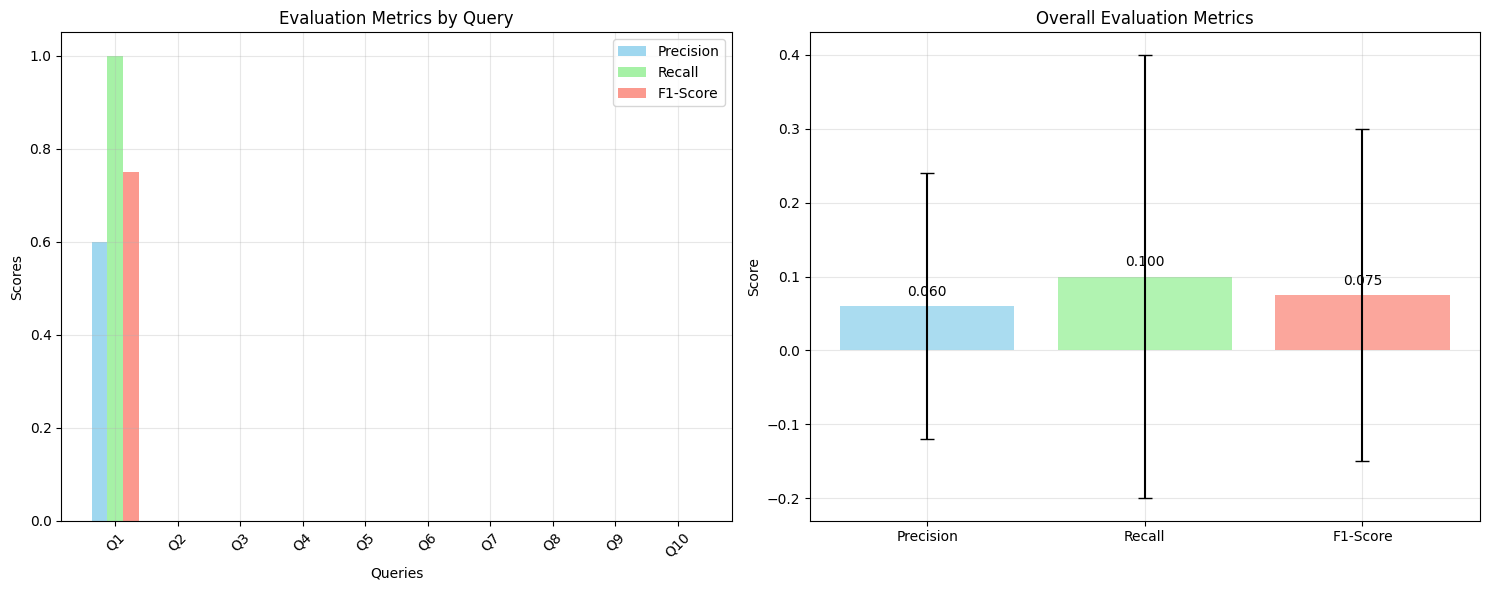


2.  COMPARING AUDIO QUALITY...
 Comparing Audio Quality...

 AUDIO QUALITY COMPARISON REPORT

  DURATION ANALYSIS:
   Original Audio: 1979.63s
   Total Segments: 1977.84s
   Coverage: 99.9%

 AUDIO METRICS COMPARISON:
Metric                    Original     Segments Avg Difference  
-----------------------------------------------------------------
RMS Energy                0.0711       0.0648          -9.0%
Max Amplitude             1.1370       0.5366         -52.8%
Spectral Centroid         1705.0163    1725.6183        1.2%
Zero Crossing Rate        0.1180       0.1199           1.6%


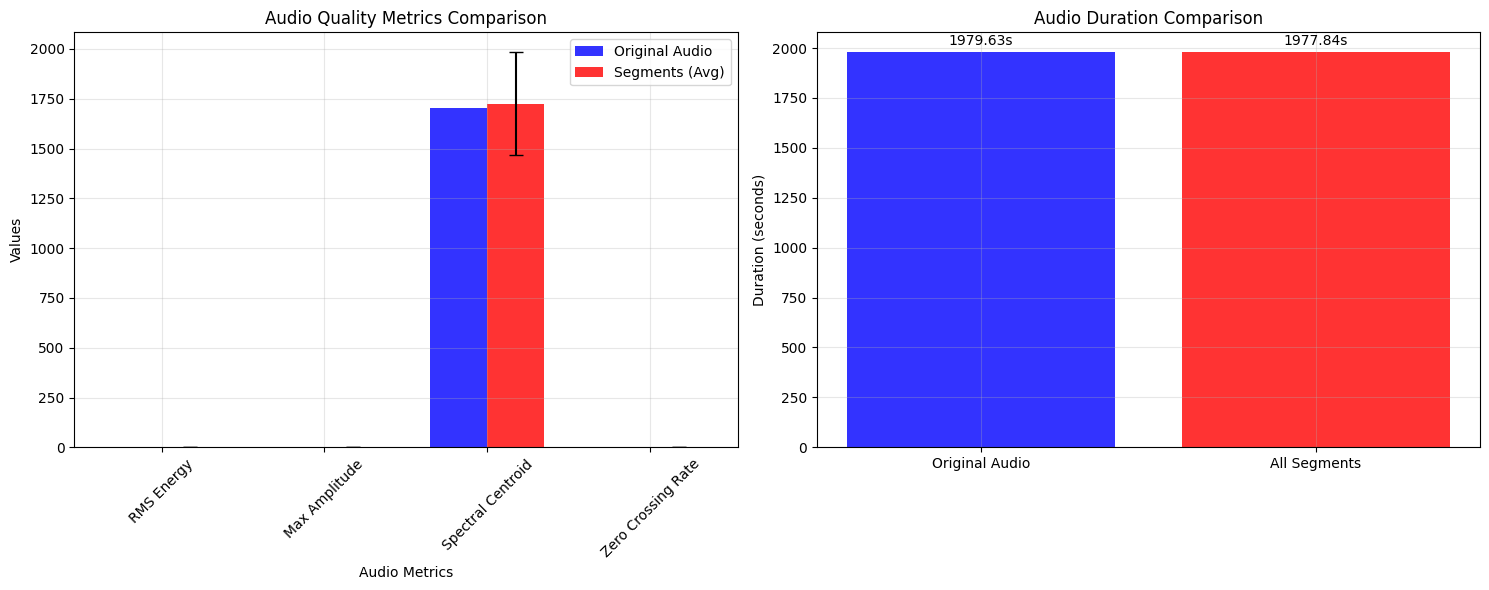

In [ ]:
# Run Comprehensive Evaluation
def run_complete_evaluation(retrieval_system, audio_path):
    """Run complete evaluation pipeline"""
    print(" STARTING COMPREHENSIVE EVALUATION PIPELINE")
    print("=" * 70)

    # Initialize evaluators
    retrieval_evaluator = AudioRetrievalEvaluator(retrieval_system)
    quality_comparator = AudioQualityComparator()

    # Test queries for evaluation
    test_queries = [
        "data structures and algorithms",
        "machine learning models",
        "database management systems",
        "computer networking protocols",
        "software development process",
        "artificial intelligence applications",
        "computer security principles",
        "web development frameworks",
        "cloud computing services",
        "operating system concepts"
    ]

    # 1. Evaluate retrieval performance
    print("\n1.  EVALUATING RETRIEVAL PERFORMANCE...")
    retrieval_results = retrieval_evaluator.comprehensive_evaluation(test_queries)
    retrieval_evaluator.generate_evaluation_report()
    retrieval_evaluator.plot_evaluation_metrics()

    # 2. Compare audio quality
    print("\n2.  COMPARING AUDIO QUALITY...")
    if hasattr(retrieval_system, 'segment_data'):
        quality_results = quality_comparator.compare_audio_quality(
            audio_path,
            retrieval_system.segment_data['segments']
        )
        if quality_results:
            quality_comparator.plot_audio_quality_comparison(quality_results)
    else:
        print(" No segment data available for quality comparison")

# Run the evaluation
evaluation_results = run_complete_evaluation(adaptive_system, audio_file)